<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/memetic_c%E1%BA%A3i_ti%E1%BA%BFn_%C4%91%E1%BB%83_cho_t%C3%A1c_v%E1%BB%A5_FL_t%C3%ADch_h%E1%BB%A3p_pruned%20local%20search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROPOTED METHOD (AVG STD)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 20
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 20, "NUM_TASKS": 500},
    {"name": "Increased Tasks", "NUM_FOG_NODES": 20, "NUM_TASKS": 1000},
    {"name": "Increased Fog Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 500},
    {"name": "Overload Scenario", "NUM_FOG_NODES": 20, "NUM_TASKS": 500, "OVERLOADED_NODES": 5}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# ========================
#   LOCAL SEARCH
# ========================
def local_search(individual, fog_nodes, tasks):
    best_individual = individual[:]
    best_fitness = fitness_function(best_individual, fog_nodes, tasks)
    for _ in range(20):
        neighbor = best_individual[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        neighbor_fitness = fitness_function(neighbor, fog_nodes, tasks)
        if neighbor_fitness < best_fitness:
            best_individual = neighbor[:]
            best_fitness = neighbor_fitness
    return best_individual

# ========================
#   TASK REASSIGNMENT
# ========================
def reassign_tasks(solution, fog_nodes, tasks):
    last_resource = max(fog_nodes, key=lambda node: compute_completion_time(node, node.current_tasks))
    worst_tasks = last_resource.current_tasks[:]
    for task in worst_tasks:
        available_nodes = [node for node in fog_nodes if node != last_resource]
        if available_nodes:
            best_node = min(available_nodes, key=lambda node: compute_completion_time(node, node.current_tasks))
            solution[tasks.index(task)] = best_node.id
            last_resource.current_tasks.remove(task)
            best_node.current_tasks.append(task)
    return solution

# ========================
#   THUẬT TOÁN MEMETIC + REASSIGNMENT
# ========================
def proposed_method(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = [best_solution[:]]

        while len(new_population) < popsize:
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = parent1[:], parent2[:]

            child1 = local_search(child1, fog_nodes, tasks)
            child2 = local_search(child2, fog_nodes, tasks)

            new_population.extend([child1, child2])

        population = new_population[:popsize]
        current_best = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
        current_fitness = fitness_function(current_best, fog_nodes, tasks)
        if current_fitness < best_fitness:
            best_solution = current_best[:]
            best_fitness = current_fitness

    best_solution = reassign_tasks(best_solution, fog_nodes, tasks)
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    return best_fitness

# ========================
#   CHẠY MÔ PHỎNG
# ========================
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)
            fitness = proposed_method(POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best: {best_fitness:.2f}, AVG: {avg_fitness:.2f}, STD: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()



=== Scenario: Basic ===
Best: 820.63, AVG: 931.12, STD: 54.53

=== Scenario: Increased Tasks ===
Best: 1758.10, AVG: 1934.96, STD: 104.22

=== Scenario: Increased Fog Nodes ===
Best: 791.54, AVG: 897.73, STD: 58.64

=== Scenario: Overload Scenario ===
Best: 798.46, AVG: 959.76, STD: 101.77


MODEL WITH "PRUNTED LOCAL SEARCH"

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 20
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0
MAX_ITERATIONS = 10  # Tham số mới cho Pruned Local Search
MAX_NEIGHBORS = 5    # Tham số mới cho Pruned Local Search

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 20, "NUM_TASKS": 500},
    {"name": "Increased Tasks", "NUM_FOG_NODES": 20, "NUM_TASKS": 1000},
    {"name": "Increased Fog Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 500},
    {"name": "Overload Scenario", "NUM_FOG_NODES": 20, "NUM_TASKS": 500, "OVERLOADED_NODES": 5}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]
    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# ========================
#   PRUNED LOCAL SEARCH
# ========================
def pruned_local_search(individual, fog_nodes, tasks, max_iterations, max_neighbors):
    # Bắt đầu với giải pháp ban đầu
    s = individual[:]
    iteration_count = 0
    best_solution = s[:]
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    # Lặp cho đến khi đạt số lần lặp tối đa
    while iteration_count < max_iterations:
        # Tạo tập hợp láng giềng ngẫu nhiên với số lượng tối đa là max_neighbors
        N = []
        for _ in range(max_neighbors):
            neighbor = s[:]
            idx = random.randint(0, len(neighbor) - 1)
            neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
            N.append(neighbor)

        # Khởi tạo best_neighbor bằng giải pháp hiện tại
        best_neighbor = s[:]
        best_neighbor_fitness = fitness_function(best_neighbor, fog_nodes, tasks)

        # Tìm láng giềng tốt nhất trong tập N
        for n in N:
            n_fitness = fitness_function(n, fog_nodes, tasks)
            if n_fitness < best_neighbor_fitness:
                best_neighbor = n[:]
                best_neighbor_fitness = n_fitness

        # Cập nhật giải pháp nếu láng giềng tốt hơn
        if best_neighbor_fitness < fitness_function(s, fog_nodes, tasks):
            s = best_neighbor[:]
            best_solution = s[:]
            best_fitness = best_neighbor_fitness

        iteration_count += 1

    return best_solution

# ========================
#   TASK REASSIGNMENT
# ========================
def reassign_tasks(solution, fog_nodes, tasks):
    last_resource = max(fog_nodes, key=lambda node: compute_completion_time(node, node.current_tasks))
    worst_tasks = last_resource.current_tasks[:]
    for task in worst_tasks:
        available_nodes = [node for node in fog_nodes if node != last_resource]
        if available_nodes:
            best_node = min(available_nodes, key=lambda node: compute_completion_time(node, node.current_tasks))
            solution[tasks.index(task)] = best_node.id
            last_resource.current_tasks.remove(task)
            best_node.current_tasks.append(task)
    return solution

# ========================
#   THUẬT TOÁN MEMETIC + REASSIGNMENT
# ========================
def proposed_method(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks, max_iterations, max_neighbors):
    population = [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    for _ in range(generations):
        fitness_values = [fitness_function(ind, fog_nodes, tasks) for ind in population]
        new_population = [best_solution[:]]

        while len(new_population) < popsize:
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = parent1[:], parent2[:]

            # Thay local_search bằng pruned_local_search với các tham số mới
            child1 = pruned_local_search(child1, fog_nodes, tasks, max_iterations, max_neighbors)
            child2 = pruned_local_search(child2, fog_nodes, tasks, max_iterations, max_neighbors)

            new_population.extend([child1, child2])

        population = new_population[:popsize]
        current_best = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
        current_fitness = fitness_function(current_best, fog_nodes, tasks)
        if current_fitness < best_fitness:
            best_solution = current_best[:]
            best_fitness = current_fitness

    best_solution = reassign_tasks(best_solution, fog_nodes, tasks)
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    return best_fitness

# ========================
#   CHẠY MÔ PHỎNG
# ========================
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks)
            fitness = proposed_method(POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks, MAX_ITERATIONS, MAX_NEIGHBORS)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best: {best_fitness:.2f}, AVG: {avg_fitness:.2f}, STD: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()


=== Scenario: Basic ===
Best: 832.23, AVG: 937.55, STD: 75.62

=== Scenario: Increased Tasks ===
Best: 1647.35, AVG: 1880.77, STD: 109.69

=== Scenario: Increased Fog Nodes ===
Best: 786.39, AVG: 846.24, STD: 42.30

=== Scenario: Overload Scenario ===
Best: 840.60, AVG: 950.77, STD: 66.91


GA

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thông số mô phỏng tối ưu
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 20
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# Kịch bản mô phỏng
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 20, "NUM_TASKS": 500},
    {"name": "Increased Tasks", "NUM_FOG_NODES": 20, "NUM_TASKS": 1000},
    {"name": "Increased Fog Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 500},
    {"name": "Overload Scenario", "NUM_FOG_NODES": 20, "NUM_TASKS": 500, "OVERLOADED_NODES": 5}
]

# Định nghĩa lớp FogNode và Task
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10  # 1 đơn vị data_size = 10 đơn vị tính toán

# Khởi tạo hệ thống theo thông số từ bảng 4
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Nếu là Overload Scenario, đặt một số node bị quá tải
    if overloaded_nodes > 0:
        overload_indices = random.sample(range(num_fog_nodes), overloaded_nodes)
        for idx in overload_indices:
            fog_nodes[idx].current_cpu_load = fog_nodes[idx].cpu_capacity * 0.9  # Gán mức tải ban đầu cao

    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính toán thời gian hoàn thành tác vụ trên một nút
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Đánh giá giải pháp
def fitness_function(solution, fog_nodes, tasks, scenario_name=""):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    total_time = sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return total_time

# Hàm chọn lọc (Roulette Selection)
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# Crossover
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Mutation
def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# Khởi tạo quần thể
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# Thuật toán GA
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks, scenario_name):
    population = initialize_population(popsize, num_tasks, num_fog_nodes)

    for _ in range(generations):
        fitnesses = [fitness_function(ind, fog_nodes, tasks, scenario_name) for ind in population]
        new_population = []
        for _ in range(popsize // 2):
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)
            child1, child2 = crossover(parent1, parent2, pcrossover)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)
            new_population.extend([child1, child2])
        population = new_population

    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks, scenario_name=scenario_name))
    return fitness_function(best_solution, fog_nodes, tasks, scenario_name=scenario_name)

# Chạy mô phỏng
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)

        fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes)

        best_fitness = genetic_algorithm(POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks, CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks, scenario["name"])

        print(f"GA Best fitness for {scenario['name']}: {best_fitness:.2f}")

# Chạy chương trình
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()



=== Scenario: Basic ===
GA Best fitness for Basic: 998.13

=== Scenario: Increased Tasks ===
GA Best fitness for Increased Tasks: 2257.06

=== Scenario: Increased Fog Nodes ===
GA Best fitness for Increased Fog Nodes: 1179.37

=== Scenario: Overload Scenario ===
GA Best fitness for Overload Scenario: 1088.99


ga có avg và std

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 20
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 20, "NUM_TASKS": 500},
    {"name": "Increased Tasks", "NUM_FOG_NODES": 20, "NUM_TASKS": 1000},
    {"name": "Increased Fog Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 500},
    {"name": "Overload Scenario", "NUM_FOG_NODES": 20, "NUM_TASKS": 500, "OVERLOADED_NODES": 5}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Nếu là Overload Scenario, đặt một số node bị quá tải
    if overloaded_nodes > 0:
        overload_indices = random.sample(range(num_fog_nodes), overloaded_nodes)
        for idx in overload_indices:
            fog_nodes[idx].current_cpu_load = fog_nodes[idx].cpu_capacity * 0.9  # Gán mức tải ban đầu cao

    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    return sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)

# ========================
#   HÀM CHỌN LỌC (Roulette Selection)
# ========================
def select(population, fitnesses):
    weights = [1 / (f + 1e-6) for f in fitnesses]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    return random.choices(population, weights=weights, k=1)[0]

# ========================
#   Crossover & Mutation
# ========================
def crossover(parent1, parent2, rate):
    if random.random() > rate:
        return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 2)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual, num_fog_nodes, rate):
    individual = individual[:]
    for i in range(len(individual)):
        if random.random() < rate:
            individual[i] = random.randint(0, num_fog_nodes - 1)
    return individual

# ========================
#   KHỞI TẠO QUẦN THỂ
# ========================
def initialize_population(popsize, num_tasks, num_fog_nodes):
    return [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

# ========================
#   THUẬT TOÁN GA HOÀN CHỈNH
# ========================
def genetic_algorithm(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    # Khởi tạo quần thể
    population = initialize_population(popsize, num_tasks, num_fog_nodes)

    for _ in range(generations):
        # Tính fitness cho từng cá thể
        fitnesses = [fitness_function(ind, fog_nodes, tasks) for ind in population]

        new_population = []
        for _ in range(popsize // 2):
            # Chọn bố mẹ bằng phương pháp Roulette Selection
            parent1 = select(population, fitnesses)
            parent2 = select(population, fitnesses)

            # Lai ghép (Crossover)
            child1, child2 = crossover(parent1, parent2, pcrossover)

            # Đột biến (Mutation)
            child1 = mutate(child1, num_fog_nodes, pmutation)
            child2 = mutate(child2, num_fog_nodes, pmutation)

            new_population.extend([child1, child2])

        # Cập nhật quần thể mới
        population = new_population

    # Chọn cá thể tốt nhất từ quần thể cuối cùng
    best_solution = min(population, key=lambda x: fitness_function(x, fog_nodes, tasks))
    return fitness_function(best_solution, fog_nodes, tasks)

# ========================
#   CHẠY MÔ PHỎNG
# ========================
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)

        # Danh sách lưu fitness của các lần chạy
        fitness_results = []

        for _ in range(NUM_RUNS):
            # Khởi tạo hệ thống
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes)

            # Chạy thuật toán GA
            fitness = genetic_algorithm(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks,
                CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            fitness_results.append(fitness)

        # Tính AVG và STD
        avg_fitness = np.mean(fitness_results)
        std_fitness = np.std(fitness_results)

        print(f"GA Results for {scenario['name']}: BEST = {min(fitness_results):.2f}, AVG = {avg_fitness:.2f}, STD = {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()



=== Scenario: Basic ===
GA Results for Basic: BEST = 892.79, AVG = 1103.37, STD = 110.48

=== Scenario: Increased Tasks ===
GA Results for Increased Tasks: BEST = 1827.17, AVG = 2231.08, STD = 240.43

=== Scenario: Increased Fog Nodes ===
GA Results for Increased Fog Nodes: BEST = 1039.57, AVG = 1146.17, STD = 75.06

=== Scenario: Overload Scenario ===
GA Results for Overload Scenario: BEST = 881.48, AVG = 1145.01, STD = 149.81


round robin

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Thông số mô phỏng tối ưu (dựa trên bảng thông số)
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 20
COMMUNICATION_PENALTY = 3.0
OVERLOAD_PENALTY = 150.0

# Kịch bản mô phỏng (đã điều chỉnh)
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 20, "NUM_TASKS": 500},
    {"name": "Increased Tasks", "NUM_FOG_NODES": 20, "NUM_TASKS": 1000},
    {"name": "Increased Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 500},
    {"name": "Overload Scenario", "NUM_FOG_NODES": 20, "NUM_TASKS": 500, "OVERLOADED_NODES": 5}  # 25% quá tải
]

# Định nghĩa lớp FogNode và Task
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10  # 1 đơn vị data_size = 10 đơn vị tính toán

# Khởi tạo hệ thống (theo bảng dữ liệu)
def initialize_system(num_fog_nodes, num_tasks, overload_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Nếu có Overload Scenario, đặt quá tải 25% số nodes đầu tiên
    for i in range(overload_nodes):
        fog_nodes[i].cpu_capacity *= 0.5  # Giảm 50% CPU capacity

    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# Tính toán thời gian hoàn thành
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# Hàm đánh giá độ phù hợp
def fitness_function(solution, fog_nodes, tasks, scenario_name=""):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    total_time = sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return total_time

# Thuật toán Round-Robin theo lý thuyết
def round_robin_assignment(tasks, fog_nodes):
    num_fog_nodes = len(fog_nodes)
    solution = [-1] * len(tasks)
    node_index = 0

    for task in tasks:
        assigned = False
        attempts = 0

        while not assigned and attempts < num_fog_nodes:
            node = fog_nodes[node_index]
            cpu_usage = (node.current_cpu_load + task.computation_size) / node.cpu_capacity

            if cpu_usage <= CPU_THRESHOLD:  # Chỉ gán nếu không quá tải
                solution[task.id] = node.id
                node.current_tasks.append(task)
                node.current_cpu_load += task.computation_size
                assigned = True

            node_index = (node_index + 1) % num_fog_nodes
            attempts += 1

        if not assigned:
            best_node = min(fog_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
            solution[task.id] = best_node.id
            best_node.current_tasks.append(task)
            best_node.current_cpu_load += task.computation_size

    return solution

# Chạy mô phỏng
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overload_nodes = scenario.get("OVERLOADED_NODES", 0)

        fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overload_nodes)

        # Thực hiện thuật toán Round-Robin
        rr_solution = round_robin_assignment(tasks, fog_nodes)
        best_fitness_rr = fitness_function(rr_solution, fog_nodes, tasks, scenario_name=scenario["name"])

        print(f"Round-Robin Best fitness for {scenario['name']}: {best_fitness_rr:.2f}")

# Chạy chương trình
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()



=== Scenario: Basic ===
Round-Robin Best fitness for Basic: 1057.09

=== Scenario: Increased Tasks ===
Round-Robin Best fitness for Increased Tasks: 2012.06

=== Scenario: Increased Nodes ===
Round-Robin Best fitness for Increased Nodes: 1112.88

=== Scenario: Overload Scenario ===
Round-Robin Best fitness for Overload Scenario: 1420.66


round robin có avg và std

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 100
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 100
CPU_THRESHOLD = 0.8
NUM_RUNS = 20
COMMUNICATION_PENALTY = 3.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 20, "NUM_TASKS": 500},
    {"name": "Increased Tasks", "NUM_FOG_NODES": 20, "NUM_TASKS": 1000},
    {"name": "Increased Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 500},
    {"name": "Overload Scenario", "NUM_FOG_NODES": 20, "NUM_TASKS": 500, "OVERLOADED_NODES": 5}  # 25% quá tải
]

# ========================
#   ĐỊNH NGHĨA LỚP FOG NODE & TASK
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_tasks = []

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_tasks = []

class Task:
    def __init__(self, id, data_size, processing_time, priority):
        self.id = id
        self.data_size = data_size
        self.processing_time = processing_time
        self.priority = priority
        self.computation_size = data_size * 10  # 1 đơn vị data_size = 10 đơn vị tính toán

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overload_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Nếu có Overload Scenario, đặt quá tải 25% số nodes đầu tiên
    for i in range(overload_nodes):
        fog_nodes[i].cpu_capacity *= 0.5  # Giảm 50% CPU capacity

    tasks = [Task(i, random.uniform(10, 100), random.uniform(1, 5), random.uniform(0.3, 0.9)) for i in range(num_tasks)]
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    return processing_time + communication_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks, scenario_name=""):
    for node in fog_nodes:
        node.reset_load()
    for task_id, node_id in enumerate(solution):
        fog_nodes[node_id].current_tasks.append(tasks[task_id])
        fog_nodes[node_id].current_cpu_load += tasks[task_id].computation_size
    total_time = sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return total_time

# ========================
#   THUẬT TOÁN ROUND-ROBIN
# ========================
def round_robin_assignment(tasks, fog_nodes):
    num_fog_nodes = len(fog_nodes)
    solution = [-1] * len(tasks)
    node_index = 0

    for task in tasks:
        assigned = False
        attempts = 0

        while not assigned and attempts < num_fog_nodes:
            node = fog_nodes[node_index]
            cpu_usage = (node.current_cpu_load + task.computation_size) / node.cpu_capacity

            if cpu_usage <= CPU_THRESHOLD:  # Chỉ gán nếu không quá tải
                solution[task.id] = node.id
                node.current_tasks.append(task)
                node.current_cpu_load += task.computation_size
                assigned = True

            node_index = (node_index + 1) % num_fog_nodes
            attempts += 1

        if not assigned:
            best_node = min(fog_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
            solution[task.id] = best_node.id
            best_node.current_tasks.append(task)
            best_node.current_cpu_load += task.computation_size

    return solution

# ========================
#   CHẠY MÔ PHỎNG
# ========================
def run_simulation():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overload_nodes = scenario.get("OVERLOADED_NODES", 0)

        # Danh sách lưu fitness của các lần chạy
        fitness_results_rr = []

        for _ in range(NUM_RUNS):
            # Khởi tạo hệ thống
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overload_nodes)

            # Thực hiện thuật toán Round-Robin
            rr_solution = round_robin_assignment(tasks, fog_nodes)
            fitness_rr = fitness_function(rr_solution, fog_nodes, tasks, scenario_name=scenario["name"])
            fitness_results_rr.append(fitness_rr)

        # Tính AVG và STD
        avg_fitness_rr = np.mean(fitness_results_rr)
        std_fitness_rr = np.std(fitness_results_rr)

        # Hiển thị kết quả
        print(f"Round-Robin Results for {scenario['name']}:")
        print(f"  ➤ BEST  = {min(fitness_results_rr):.2f}")
        print(f"  ➤ AVG   = {avg_fitness_rr:.2f}")
        print(f"  ➤ STD   = {std_fitness_rr:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_simulation()



=== Scenario: Basic ===
Round-Robin Results for Basic:
  ➤ BEST  = 1009.48
  ➤ AVG   = 1210.81
  ➤ STD   = 138.12

=== Scenario: Increased Tasks ===
Round-Robin Results for Increased Tasks:
  ➤ BEST  = 1992.92
  ➤ AVG   = 2455.73
  ➤ STD   = 234.38

=== Scenario: Increased Nodes ===
Round-Robin Results for Increased Nodes:
  ➤ BEST  = 1005.42
  ➤ AVG   = 1215.10
  ➤ STD   = 129.92

=== Scenario: Overload Scenario ===
Round-Robin Results for Overload Scenario:
  ➤ BEST  = 1058.24
  ➤ AVG   = 1183.17
  ➤ STD   = 94.42


vẽ sơ đồ so sánh

3d std

<ipython-input-16-c1b54a3ae1b7>:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


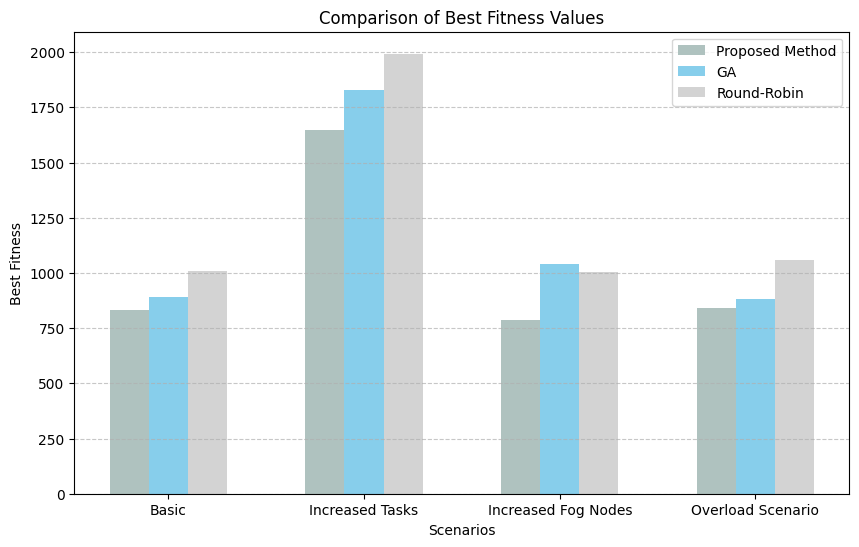

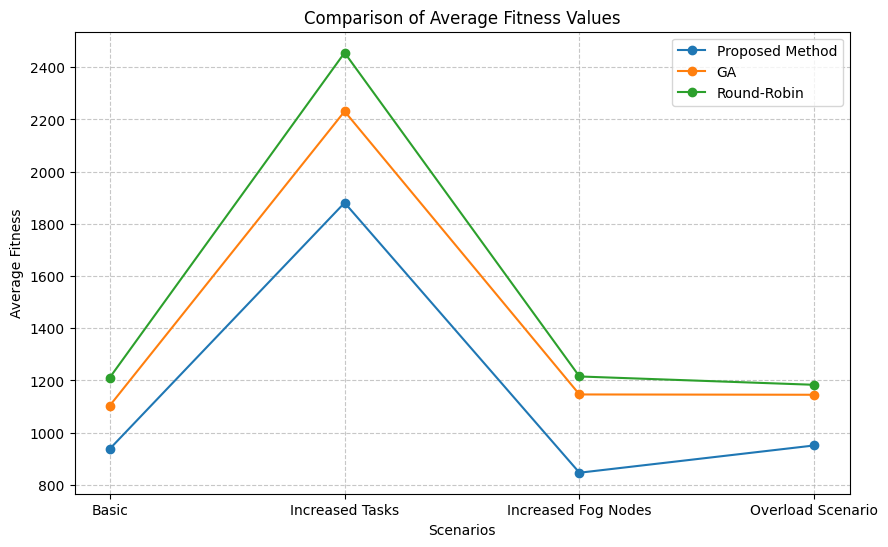

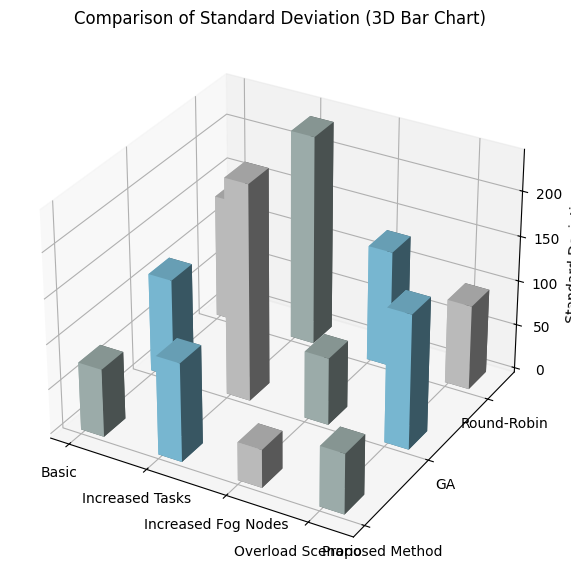

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dữ liệu từ bảng kết quả thực nghiệm
scenarios = ["Basic", "Increased Tasks", "Increased Fog Nodes", "Overload Scenario"]

best_results = {
    "Proposed Method": [832.23, 1647.35, 786.39, 840.60],
    "GA": [892.79, 1827.17, 1039.57, 881.48],
    "Round-Robin": [1009.48, 1992.92, 1005.42, 1058.24]
}

avg_results = {
    "Proposed Method": [937.55, 1880.77, 846.24, 950.77],
    "GA": [1103.37, 2231.08, 1146.17, 1145.01],
    "Round-Robin": [1210.81, 2455.73, 1215.10, 1183.17]
}

std_results = {
    "Proposed Method": [75.62, 109.69, 42.30, 66.91],
    "GA": [110.48, 240.43, 75.06, 149.81],
    "Round-Robin": [138.12, 234.38, 129.92, 94.42]
}

# ===========
#  BIỂU ĐỒ 1: BEST (Bar chart)
# ===========
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
x = np.arange(len(scenarios))

ax.bar(x - bar_width, best_results["Proposed Method"], bar_width, label="Proposed Method", color="#AFC2BF")
ax.bar(x, best_results["GA"], bar_width, label="GA", color="#87CEEB")
ax.bar(x + bar_width, best_results["Round-Robin"], bar_width, label="Round-Robin", color="#D3D3D3")

ax.set_xlabel("Scenarios")
ax.set_ylabel("Best Fitness")
ax.set_title("Comparison of Best Fitness Values")
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# ===========
#  BIỂU ĐỒ 2: AVG (Line plot)
# ===========
fig, ax = plt.subplots(figsize=(10, 6))

for method, values in avg_results.items():
    ax.plot(scenarios, values, marker="o", label=method)

ax.set_xlabel("Scenarios")
ax.set_ylabel("Average Fitness")
ax.set_title("Comparison of Average Fitness Values")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.7)

# ===========
#  BIỂU ĐỒ 3: STD (3D Bar Chart)
# ===========
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

bar_width = 0.3
x = np.arange(len(scenarios))
y_labels = list(std_results.keys())
y = np.arange(len(y_labels))

xpos, ypos = np.meshgrid(x, y)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dz = np.array([std_results[method][i] for method in y_labels for i in range(len(scenarios))])

ax.bar3d(xpos, ypos, zpos, bar_width, bar_width, dz, shade=True, color=["#AFC2BF", "#87CEEB", "#D3D3D3"] * len(scenarios))

ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_zlabel("Standard Deviation")
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.set_yticks(y)
ax.set_yticklabels(y_labels)
ax.set_title("Comparison of Standard Deviation (3D Bar Chart)")

plt.tight_layout()
plt.show()


<ipython-input-15-3768d2e28514>:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


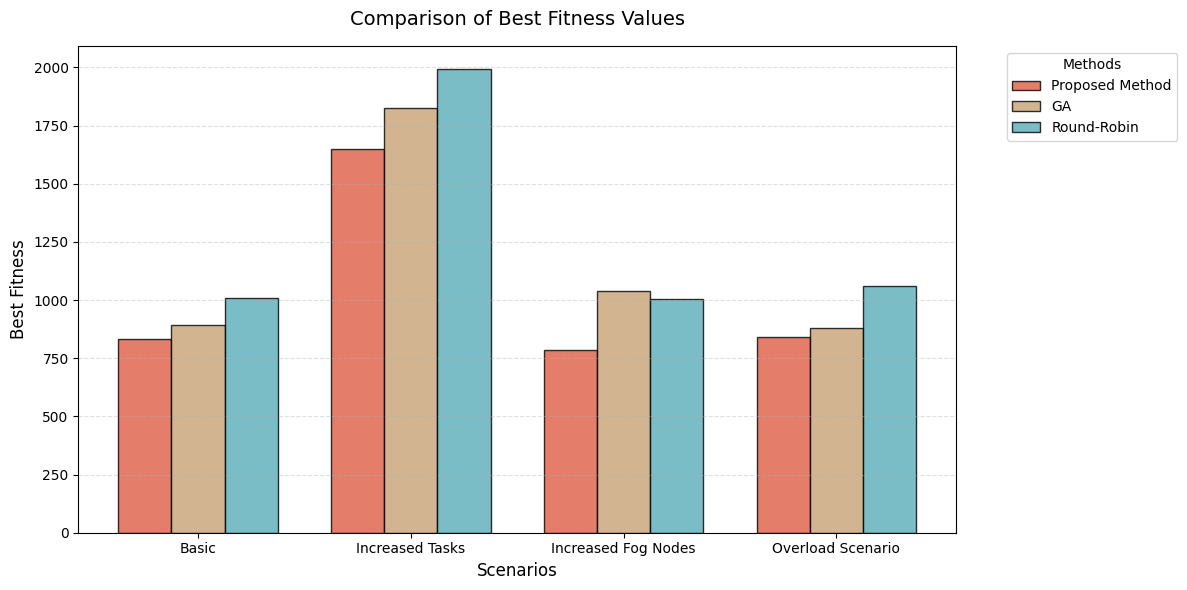

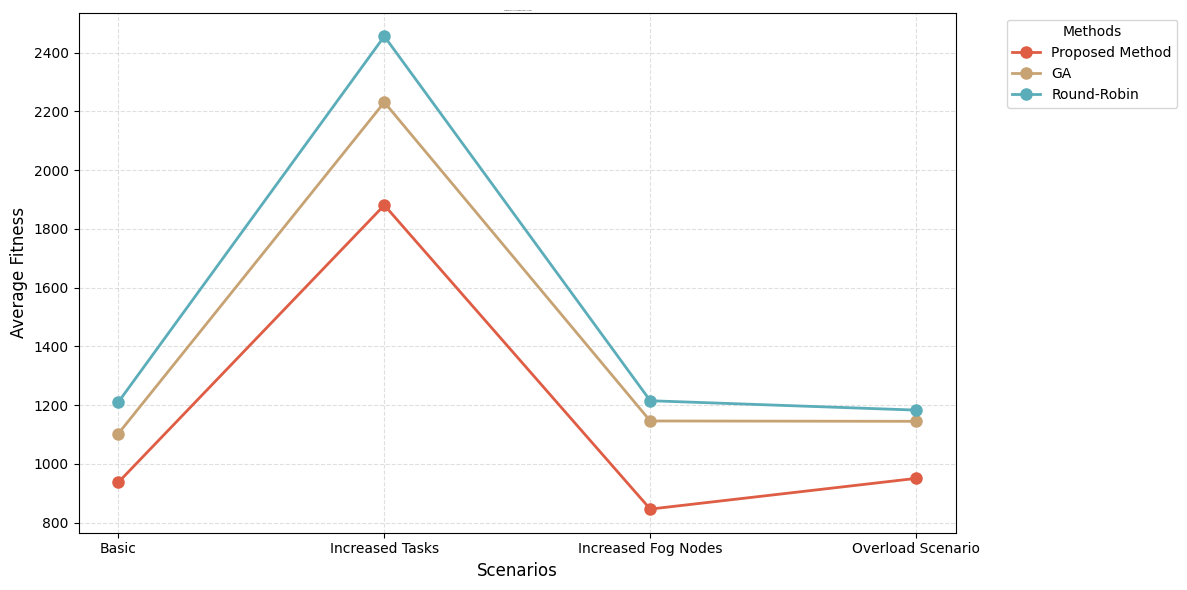

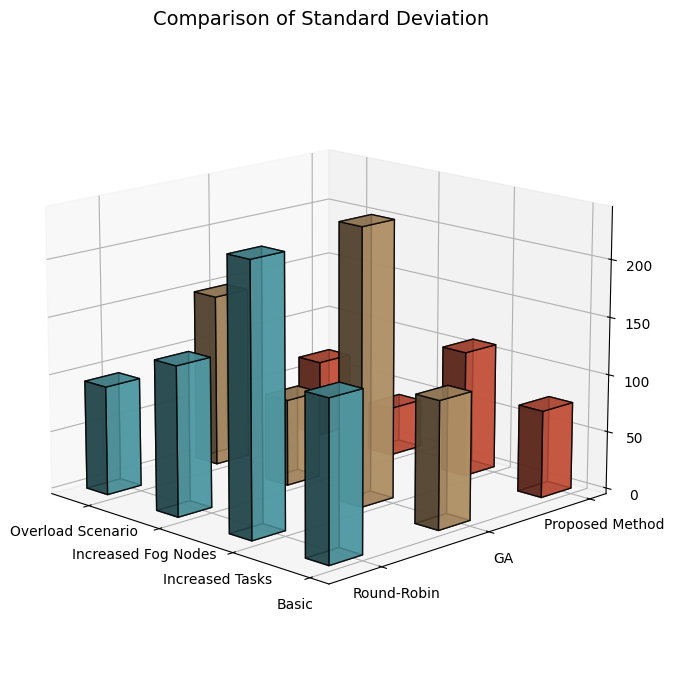

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dữ liệu từ bảng kết quả thực nghiệm
scenarios = ["Basic", "Increased Tasks", "Increased Fog Nodes", "Overload Scenario"]

best_results = {
    "Proposed Method": [832.23, 1647.35, 786.39, 840.60],
    "GA": [892.79, 1827.17, 1039.57, 881.48],
    "Round-Robin": [1009.48, 1992.92, 1005.42, 1058.24]
}

avg_results = {
    "Proposed Method": [937.55, 1880.77, 846.24, 950.77],
    "GA": [1103.37, 2231.08, 1146.17, 1145.01],
    "Round-Robin": [1210.81, 2455.73, 1215.10, 1183.17]
}

std_results = {
    "Proposed Method": [75.62, 109.69, 42.30, 66.91],
    "GA": [110.48, 240.43, 75.06, 149.81],
    "Round-Robin": [138.12, 234.38, 129.92, 94.42]
}

# Màu sắc thống nhất
colors = {"Proposed Method": "#de5d44", "GA": "#c7a374", "Round-Robin": "#5aadb9"}

# ===========
# BIỂU ĐỒ 1: BEST (Bar chart) - Cải tiến
# ===========
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(scenarios))

for i, (method, values) in enumerate(best_results.items()):
    plt.bar(x + i*bar_width, values, bar_width, label=method,
            color=colors[method], alpha=0.8, edgecolor='black')

plt.xlabel("Scenarios", fontsize=12)
plt.ylabel("Best Fitness", fontsize=12)
plt.title("Comparison of Best Fitness Values", fontsize=14, pad=15)
plt.xticks(x + bar_width, scenarios, rotation=0)
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

# ===========
# BIỂU ĐỒ 2: AVG (Line plot) - Cải tiến
# ===========
plt.figure(figsize=(12, 6))

for method, values in avg_results.items():
    plt.plot(scenarios, values, marker="o", markersize=8,
             linewidth=2, label=method, color=colors[method])

plt.xlabel("Scenarios", fontsize=12)
plt.ylabel("Average Fitness", fontsize=12)
plt.title("Comparison of Average Fitness Values", fontsize=1, pad=1)
plt.xticks(rotation=0)
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

# ===========
# BIỂU ĐỒ 3: STD (3D Bar Chart) - Cải tiến
# ===========
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

bar_width = 0.3
x = np.arange(len(scenarios))
y_labels = list(std_results.keys())
y = np.arange(len(y_labels))

xpos, ypos = np.meshgrid(x, y)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dz = np.array([std_results[method][i] for method in y_labels for i in range(len(scenarios))])

# Sử dụng màu sắc nhất quán
colors_3d = [colors[method] for method in y_labels for _ in range(len(scenarios))]
bars = ax.bar3d(xpos, ypos, zpos, bar_width, bar_width, dz,
                color=colors_3d, alpha=0.8, edgecolor='black')

ax.set_xlabel(" ", fontsize=12, labelpad=10)
ax.set_ylabel(" ", fontsize=12, labelpad=10)
ax.set_zlabel("Standard Deviation", fontsize=12, labelpad=10)
ax.set_title("Comparison of Standard Deviation", fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=0)
ax.set_yticks(y)
ax.set_yticklabels(y_labels)
ax.view_init(elev=15, azim=135)  # Điều chỉnh góc nhìn

plt.tight_layout()
plt.show()